## Step 1: Import Libraries and Load Data
Load the required libraries and datasets: `Customers.csv` and `Transactions.csv`.


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV files


Saving Customers.csv to Customers.csv
Saving Products.csv to Products.csv
Saving Transactions.csv to Transactions.csv


In [3]:
import os
print(os.listdir())  # List all files in the current directory


['.config', 'Customers.csv', 'Transactions.csv', 'Products.csv', 'sample_data']


In [4]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows to confirm
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


## Step 2: Data Preprocessing
### Actions:
1. Merge customer and transaction datasets.
2. Normalize numerical features (`Quantity`, `TotalValue`) using `StandardScaler`.
3. Encode categorical features (`Region`, `ProductID`) using `LabelEncoder`.


In [5]:
data = customers.merge(transactions, on='CustomerID', how='left')


In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Quantity', 'TotalValue']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Encode categorical features
encoder = LabelEncoder()
data['Region'] = encoder.fit_transform(data['Region'])
data['ProductID'] = encoder.fit_transform(data['ProductID'])

# Display processed data
print(data.head())


  CustomerID      CustomerName  Region  SignupDate TransactionID  ProductID  \
0      C0001  Lawrence Carroll       3  2022-07-10        T00015         53   
1      C0001  Lawrence Carroll       3  2022-07-10        T00932         21   
2      C0001  Lawrence Carroll       3  2022-07-10        T00085         95   
3      C0001  Lawrence Carroll       3  2022-07-10        T00445         82   
4      C0001  Lawrence Carroll       3  2022-07-10        T00436         28   

       TransactionDate  Quantity  TotalValue   Price  
0  2024-01-19 03:12:55 -0.480571   -1.167373   57.30  
1  2024-09-17 09:01:18  0.414347   -0.562745  137.54  
2  2024-04-08 00:01:00 -0.480571   -0.152274  307.47  
3  2024-05-07 03:11:44 -0.480571    0.449270  455.72  
4  2024-11-02 17:04:16  0.414347    1.239454  433.64  


## Step 3: Similarity Calculation
### Actions:
1. Aggregate customer-level features by averaging numerical and encoded categorical data.
2. Compute similarity scores using `Cosine Similarity`.
3. Store results in a similarity matrix.


In [7]:
# Aggregate customer-level features
numeric_columns = data.select_dtypes(include=['number']).columns
customer_features = data.groupby('CustomerID')[numeric_columns].mean()

# Display the processed DataFrame
print(customer_features.head())



            Region  ProductID  Quantity  TotalValue       Price
CustomerID                                                     
C0001          3.0  55.800000 -0.122604   -0.038733  278.334000
C0002          0.0  46.250000 -0.033112   -0.455085  208.920000
C0003          3.0  16.000000  0.861805   -0.017550  195.707500
C0004          3.0  45.375000  0.302482   -0.041866  240.636250
C0005          0.0  24.333333 -0.182265   -0.024175  291.603333


In [8]:
print(customer_features.isnull().sum())



Region        0
ProductID     0
Quantity      1
TotalValue    1
Price         1
dtype: int64


In [9]:
customer_features.fillna(0, inplace=True)


In [10]:
print(customer_features.isnull().sum().sum())  # Should return 0


0


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix
similarity_matrix = cosine_similarity(customer_features)

# Convert to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix,
                             index=customer_features.index,
                             columns=customer_features.index)

# Display a preview of the similarity DataFrame
print(similarity_df.head())


CustomerID     C0001     C0002     C0003     C0004     C0005     C0006  \
CustomerID                                                               
C0001       1.000000  0.999742  0.993225  0.999931  0.993385  0.999565   
C0002       0.999742  1.000000  0.990599  0.999426  0.990952  0.998734   
C0003       0.993225  0.990599  1.000000  0.994505  0.999869  0.996193   
C0004       0.999931  0.999426  0.994505  1.000000  0.994611  0.999833   
C0005       0.993385  0.990952  0.999869  0.994611  1.000000  0.996321   

CustomerID     C0007     C0008     C0009     C0010  ...     C0191     C0192  \
CustomerID                                          ...                       
C0001       0.999674  0.999879  0.999853  0.996646  ...  0.999949  0.995959   
C0002       0.999990  0.999951  0.999380  0.998073  ...  0.999491  0.993909   
C0003       0.990161  0.991329  0.994738  0.980421  ...  0.994343  0.999622   
C0004       0.999322  0.999630  0.999935  0.995638  ...  0.999995  0.996919   
C0005  

## Step 4: Generate Recommendations
### Actions:
1. For each of the first 20 customers, find the top 3 most similar customers based on similarity scores.
2. Save recommendations in a CSV file with the following format:


In [12]:
# Get top 3 similar customers for the first 20 customers
def get_top_3_similar(customers_df, similarity_df):
    results = []
    for customer_id in customers_df['CustomerID'][:20]:
        similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False).iloc[1:4]
        results.append({
            'cust_id': customer_id,
            'recommendations': [(idx, round(score, 4)) for idx, score in similar_customers.items()]
        })
    return results

# Generate recommendations
recommendations = get_top_3_similar(customers, similarity_df)

# Display recommendations
for rec in recommendations:
    print(f"Customer: {rec['cust_id']}, Recommendations: {rec['recommendations']}")


Customer: C0001, Recommendations: [('C0174', 1.0), ('C0098', 1.0), ('C0122', 1.0)]
Customer: C0002, Recommendations: [('C0123', 1.0), ('C0093', 1.0), ('C0007', 1.0)]
Customer: C0003, Recommendations: [('C0137', 1.0), ('C0079', 0.9999), ('C0085', 0.9999)]
Customer: C0004, Recommendations: [('C0191', 1.0), ('C0120', 1.0), ('C0194', 1.0)]
Customer: C0005, Recommendations: [('C0186', 1.0), ('C0079', 1.0), ('C0040', 1.0)]
Customer: C0006, Recommendations: [('C0125', 1.0), ('C0087', 1.0), ('C0035', 1.0)]
Customer: C0007, Recommendations: [('C0123', 1.0), ('C0167', 1.0), ('C0002', 1.0)]
Customer: C0008, Recommendations: [('C0047', 1.0), ('C0130', 1.0), ('C0116', 1.0)]
Customer: C0009, Recommendations: [('C0184', 1.0), ('C0056', 1.0), ('C0065', 1.0)]
Customer: C0010, Recommendations: [('C0109', 1.0), ('C0014', 1.0), ('C0038', 1.0)]
Customer: C0011, Recommendations: [('C0133', 1.0), ('C0104', 1.0), ('C0018', 1.0)]
Customer: C0012, Recommendations: [('C0163', 1.0), ('C0102', 1.0), ('C0076', 1.0)

In [13]:
# Prepare recommendations for CSV
lookalike_data = []
for rec in recommendations:
    row = [rec['cust_id']]
    for cust, score in rec['recommendations']:
        row.extend([cust, score])
    lookalike_data.append(row)

# Define column names
columns = ["cust_id", "recommended_cust_id_1", "score_1", "recommended_cust_id_2", "score_2", "recommended_cust_id_3", "score_3"]

# Create a DataFrame
lookalike_df = pd.DataFrame(lookalike_data, columns=columns)

# Save to CSV
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)

print("Lookalike recommendations saved to 'FirstName_LastName_Lookalike.csv'")


Lookalike recommendations saved to 'FirstName_LastName_Lookalike.csv'


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd


In [15]:
# Store results for evaluation
db_scores = []
k_values = list(range(2, 11))

# Loop through the range of clusters
for k in k_values:
    # Initialize and fit the K-Means model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features)

    # Predict cluster assignments
    clusters = kmeans.labels_

    # Compute Davies-Bouldin Index
    db_score = davies_bouldin_score(customer_features, clusters)
    db_scores.append(db_score)

    print(f"Number of Clusters: {k}, Davies-Bouldin Index: {db_score}")


Number of Clusters: 2, Davies-Bouldin Index: 0.7146230323132255
Number of Clusters: 3, Davies-Bouldin Index: 0.6727436710112352
Number of Clusters: 4, Davies-Bouldin Index: 0.5974158364472919
Number of Clusters: 5, Davies-Bouldin Index: 0.6630727276563411
Number of Clusters: 6, Davies-Bouldin Index: 0.6978886913354782
Number of Clusters: 7, Davies-Bouldin Index: 0.683925940983216
Number of Clusters: 8, Davies-Bouldin Index: 0.7250384322852328
Number of Clusters: 9, Davies-Bouldin Index: 0.8057532394802337
Number of Clusters: 10, Davies-Bouldin Index: 0.7876538497007481


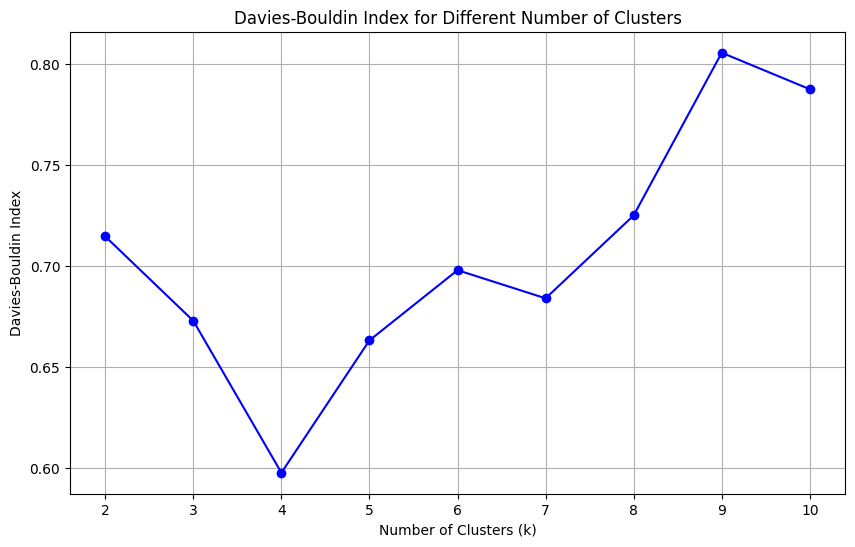

In [16]:
# Plot DBI scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid()
plt.show()


In [17]:
# Fit K-Means with the optimal number of clusters (example: 3)
optimal_k = 3  # Replace with your optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features)

# Save results to CSV
customer_features.to_csv('FirstName_LastName_Clustering.csv', index=True)
print("Clustering results saved to 'FirstName_LastName_Clustering.csv'")


Clustering results saved to 'FirstName_LastName_Clustering.csv'
